In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
# Load the competition datasets into Pandas DataFrame
train_proteins = pd.read_csv("~/Documents/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptides = pd.read_csv("~/Documents/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
train_clinical = pd.read_csv("~/Documents/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
supplemental_clinical = pd.read_csv("~/Documents/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv")

In [3]:
print(train_clinical.shape)
print(train_peptides.shape)
print(train_proteins.shape)
print(supplemental_clinical.shape)

(2615, 8)
(981834, 6)
(232741, 5)
(2223, 8)


In [4]:
train_clinical.head(10)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [5]:
train_peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [6]:
train_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [7]:
supplemental_clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN


In [8]:
# Determining the number of unique patients in the datasets.

patient_count = train_clinical['patient_id'].nunique()
print(f'There are {patient_count} number of unique patients in "train_clinical_data.csv"')

patient_count1 = train_peptides['patient_id'].nunique()
print(f'There are {patient_count1} number of unique patients in "train_peptides.csv"')

patient_count2 = train_proteins['patient_id'].nunique()
print(f'There are {patient_count2} number of unique patients in "train_proteins.csv"')
      
patient_count3 = supplemental_clinical['patient_id'].nunique()
print(f'There are {patient_count3} number of unique patients in "supplemental_clinical_data.csv"')

There are 248 number of unique patients in "train_clinical_data.csv"
There are 248 number of unique patients in "train_peptides.csv"
There are 248 number of unique patients in "train_proteins.csv"
There are 771 number of unique patients in "supplemental_clinical_data.csv"


In [9]:
# list all the unique patient_id values. 
train_clinical['patient_id'].unique()

array([   55,   942,  1517,  1923,  2660,  3636,  3863,  4161,  4172,
        4923,  5027,  5036,  5178,  5645,  5742,  6054,  6211,  6420,
        7051,  7117,  7151,  7265,  7508,  7568,  7832,  7886,  8344,
        8699, 10053, 10138, 10174, 10541, 10715, 10718, 11459, 11686,
       11928, 12516, 12636, 12703, 12755, 12931, 13360, 13368, 13618,
       13804, 13852, 13968, 14035, 14124, 14242, 14270, 14344, 14450,
       14811, 15009, 15245, 15504, 15590, 16238, 16347, 16566, 16574,
       16778, 16931, 17154, 17201, 17414, 17727, 18183, 18204, 18553,
       18560, 19088, 20212, 20216, 20352, 20404, 20460, 20581, 20664,
       20707, 20791, 20792, 21126, 21537, 21729, 22126, 22623, 23175,
       23192, 23244, 23391, 23636, 24278, 24690, 24818, 24820, 24911,
       25562, 25739, 25750, 25827, 25911, 26005, 26104, 26210, 26809,
       27079, 27300, 27464, 27468, 27607, 27715, 27872, 27893, 27971,
       27987, 28327, 28342, 28818, 29313, 29417, 30119, 30155, 30416,
       30894, 30951,

In [10]:
# Look at the complete clincal data for one patient: patient_id = 55
train_clinical[train_clinical['patient_id']==55]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [11]:
# Look at the complete clincal data for another patient: patient_id = 942
train_clinical[train_clinical['patient_id']==942]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
13,942_0,942,0,3.0,2.0,20.0,NaN,NaN
14,942_3,942,3,7.0,2.0,17.0,NaN,NaN
15,942_6,942,6,8.0,2.0,21.0,NaN,NaN
16,942_12,942,12,5.0,2.0,25.0,0.0,NaN
17,942_18,942,18,6.0,5.0,18.0,0.0,NaN
18,942_24,942,24,2.0,3.0,23.0,NaN,NaN
19,942_30,942,30,4.0,4.0,19.0,0.0,NaN
20,942_36,942,36,2.0,4.0,19.0,0.0,NaN
21,942_42,942,42,2.0,3.0,32.0,0.0,NaN
22,942_48,942,48,2.0,6.0,35.0,0.0,NaN


In [12]:
# Look at the complete clincal data for another patient: patient_id = 1517
train_clinical[train_clinical['patient_id']==1517]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
28,1517_0,1517,0,11.0,6.0,25.0,5.0,On
29,1517_6,1517,6,17.0,4.0,30.0,7.0,On
30,1517_12,1517,12,20.0,11.0,32.0,5.0,On
31,1517_18,1517,18,23.0,14.0,25.0,5.0,On
32,1517_24,1517,24,19.0,11.0,28.0,3.0,On
33,1517_30,1517,30,20.0,15.0,39.0,10.0,Off
34,1517_36,1517,36,20.0,17.0,31.0,8.0,On
35,1517_42,1517,42,15.0,13.0,37.0,4.0,On
36,1517_48,1517,48,20.0,18.0,40.0,6.0,Off
37,1517_60,1517,60,19.0,18.0,39.0,10.0,Off


In [13]:
# I notice a lot of NaN values in the previous patient data, especially in 'clinical_state_on_medication' column,
# so let's count all the NaN values in each column.

train_clinical.isna().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

In [14]:
# counting the number of unique scores in 'updrs_4' and their occurances.
train_clinical['updrs_4'].value_counts()

0.0     961
3.0     107
4.0      86
2.0      83
5.0      82
1.0      64
6.0      55
7.0      40
8.0      27
9.0      22
10.0     17
11.0      8
13.0      7
14.0      7
12.0      5
16.0      3
20.0      1
15.0      1
17.0      1
Name: updrs_4, dtype: int64

In [15]:
# counting the number of unique scores for 'clinical state on medication' and their occurances.

train_clinical['upd23b_clinical_state_on_medication'].value_counts()

On     775
Off    513
Name: upd23b_clinical_state_on_medication, dtype: int64

In [16]:
# I decide to drop the "medication status" column (due to over 50% NaN values).

train_clinical.drop('upd23b_clinical_state_on_medication', axis=1, inplace=True)


In [17]:
train_clinical

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0
4,55_12,55,12,10.0,10.0,41.0,0.0
...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0
2611,65043_54,65043,54,4.0,8.0,11.0,1.0
2612,65043_60,65043,60,6.0,6.0,16.0,1.0
2613,65043_72,65043,72,3.0,9.0,14.0,1.0


In [18]:
# and use interpolate() on the rest of the dataset.

train_clinical['updrs_1'].interpolate(method='linear', limit_direction='both', inplace=True)
train_clinical['updrs_2'].interpolate(method='linear', limit_direction='both', inplace=True)
train_clinical['updrs_3'].interpolate(method='linear', limit_direction='both', inplace=True)
train_clinical['updrs_4'].interpolate(method='linear', limit_direction='both', inplace=True)

In [19]:
# no more NaN values remaining. 

train_clinical.isna().sum()

visit_id       0
patient_id     0
visit_month    0
updrs_1        0
updrs_2        0
updrs_3        0
updrs_4        0
dtype: int64

In [20]:
# let's look at the other datasets. 

train_peptides.isnull().sum()

visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
dtype: int64

In [21]:
train_proteins.isnull().sum()

visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
dtype: int64

In [22]:
supplemental_clinical.isnull().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                 213
updrs_2                                 214
updrs_3                                   5
updrs_4                                 928
upd23b_clinical_state_on_medication    1101
dtype: int64

In [23]:
# we'll also drop the 'medication' column and interpolate the rest using the same method.
supplemental_clinical.drop('upd23b_clinical_state_on_medication', axis=1, inplace=True)


In [24]:
supplemental_clinical['updrs_1'].interpolate(method='linear', limit_direction='both', inplace=True)
supplemental_clinical['updrs_2'].interpolate(method='linear', limit_direction='both', inplace=True)
supplemental_clinical['updrs_3'].interpolate(method='linear', limit_direction='both', inplace=True)
supplemental_clinical['updrs_4'].interpolate(method='linear', limit_direction='both', inplace=True)

In [25]:
supplemental_clinical.isnull().sum()

visit_id       0
patient_id     0
visit_month    0
updrs_1        0
updrs_2        0
updrs_3        0
updrs_4        0
dtype: int64

In [33]:
cols = ['visit_month','updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
train_clinical[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
visit_month,2615.0,31.190822,25.199053,0.0,10.5,24.0,48.0,108.0
updrs_1,2615.0,7.109560,5.525134,0.0,3.0,6.0,10.0,33.0
updrs_2,2615.0,6.742256,6.322507,0.0,1.0,5.0,10.0,40.0
updrs_3,2615.0,19.453537,14.958571,0.0,6.0,19.0,29.0,86.0
updrs_4,2615.0,1.804398,2.802758,0.0,0.0,0.0,3.0,20.0


In [35]:
supplemental_clinical[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
visit_month,2223.0,12.910481,13.060532,0.0,0.0,6.0,24.0,36.0
updrs_1,2223.0,5.790148,4.296143,0.0,3.0,5.0,8.0,27.0
updrs_2,2223.0,6.618534,4.888636,0.0,3.0,6.0,10.0,34.0
updrs_3,2223.0,22.930274,12.336572,0.0,14.0,22.0,31.0,72.0
updrs_4,2223.0,0.956365,1.798018,0.0,0.0,0.0,1.2,12.0


In [36]:
train_clinical['source'] = 'Clinical Data'
supplemental_clinical['source'] = 'Supplemental Data'

combined_data = pd.concat([train_clinical, supplemental_clinical],ignore_index=True)

In [48]:
combined_data

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,source
0,55_0,55,0,10.0,6.0,15.0,0.0,Clinical Data
1,55_3,55,3,10.0,7.0,25.0,0.0,Clinical Data
2,55_6,55,6,8.0,10.0,34.0,0.0,Clinical Data
3,55_9,55,9,8.0,9.0,30.0,0.0,Clinical Data
4,55_12,55,12,10.0,10.0,41.0,0.0,Clinical Data
...,...,...,...,...,...,...,...,...
4833,65382_0,65382,0,4.5,8.5,0.0,0.0,Supplemental Data
4834,65405_0,65405,0,5.0,16.0,31.0,0.0,Supplemental Data
4835,65405_5,65405,5,7.5,11.0,57.0,0.0,Supplemental Data
4836,65530_0,65530,0,10.0,6.0,24.0,0.0,Supplemental Data


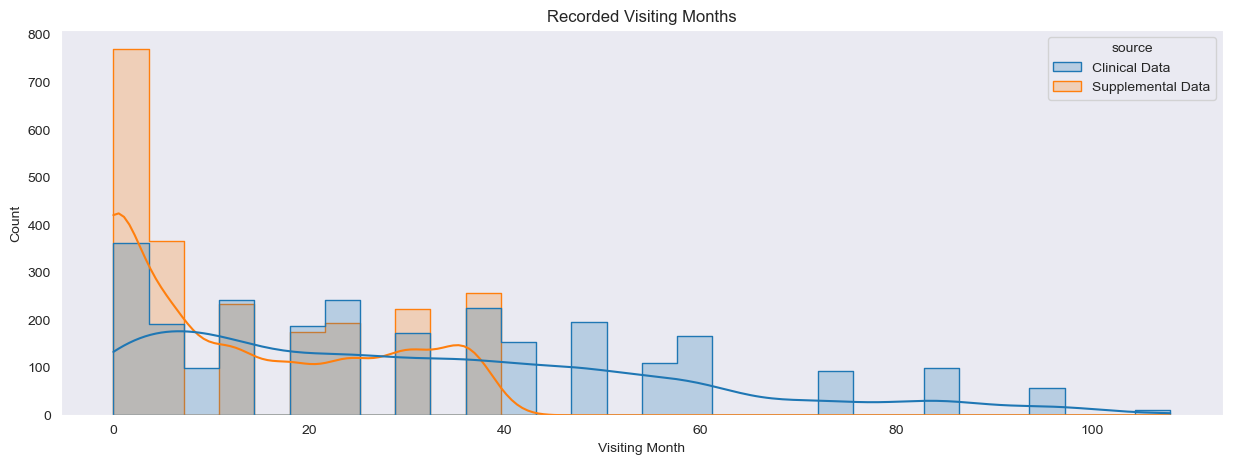

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
sns.set_style('dark')
sns.histplot(data=combined_data, x='visit_month', hue='source', kde=True, ax=ax, element='step')
ax.set_title('Recorded Visiting Months')
ax.set_ylabel('Count')
ax.set_xlabel('Visiting Month');

This makes sense since the patients enrolled in the clinical study are likely to have been followed up for longer periods, and also probably show more compliance to the study. 

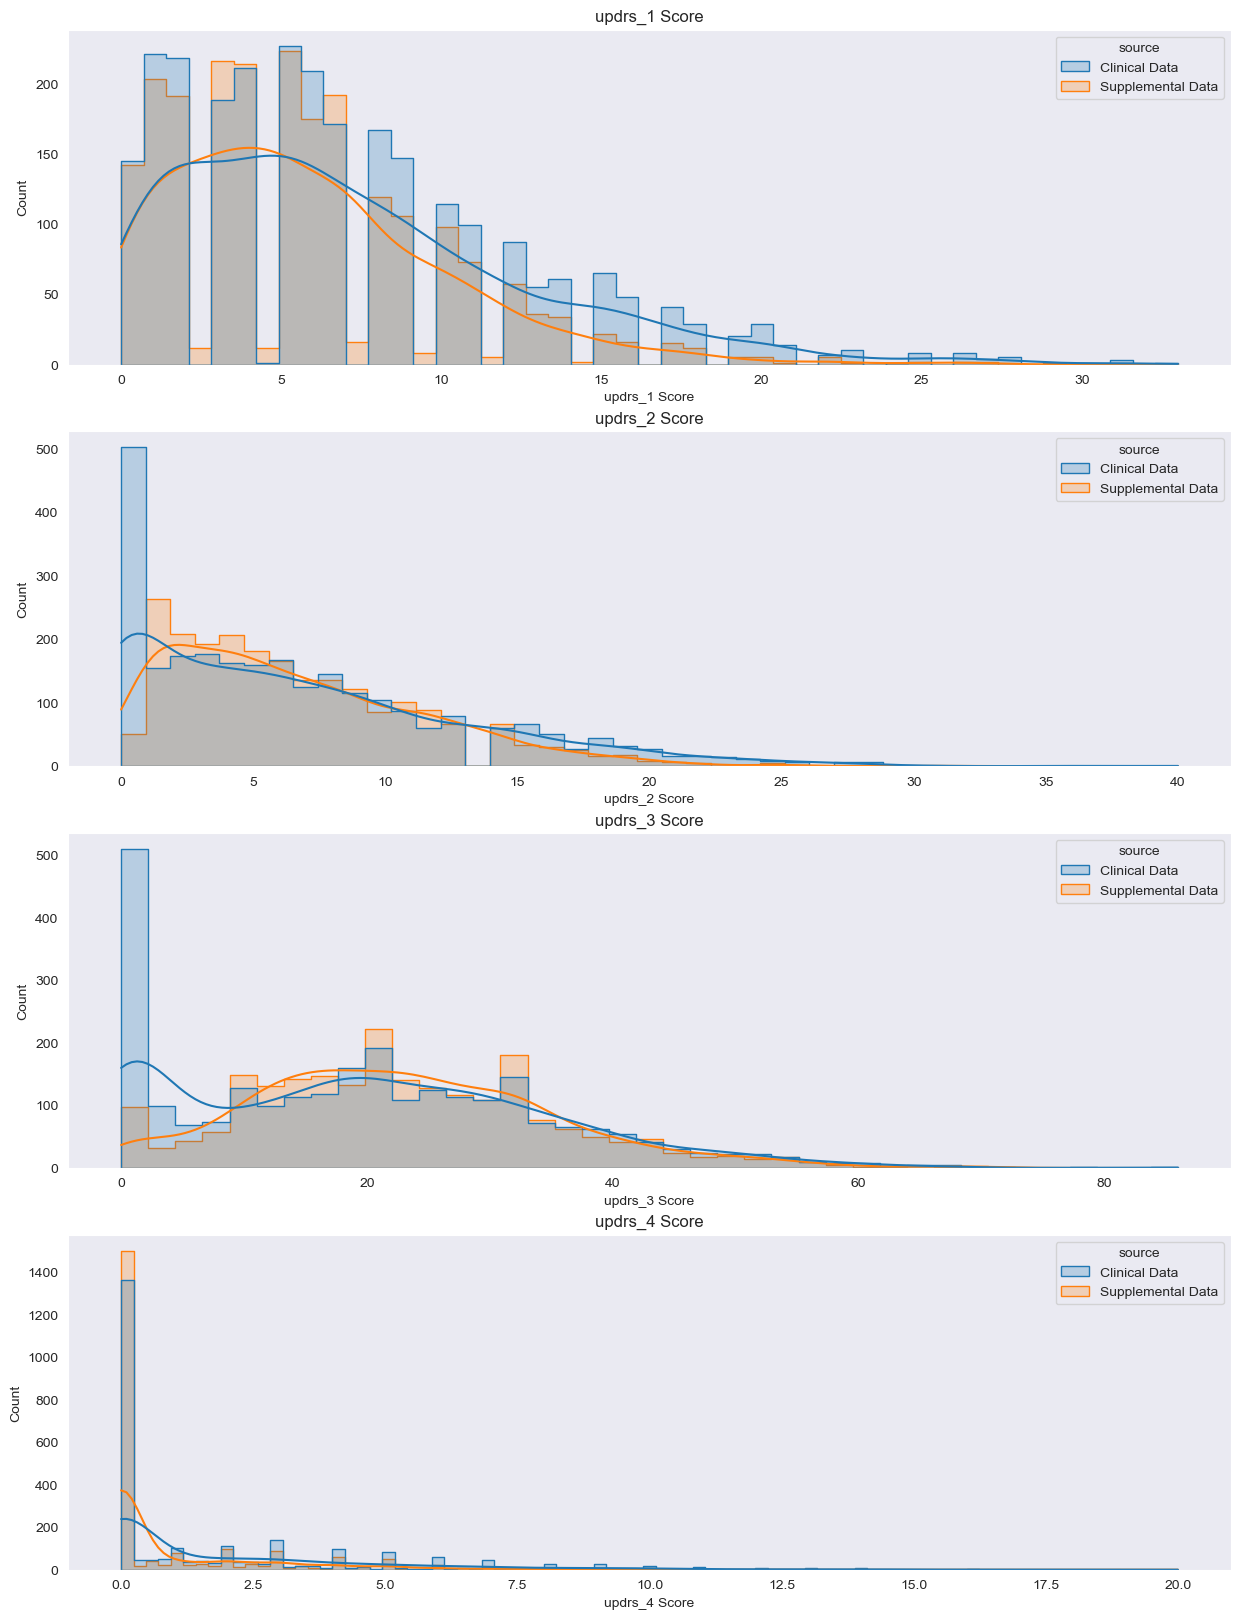

In [69]:
cols = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,20))
sns.set_style('dark')

for x, col in enumerate(cols):
    ax = axs[x]
    sns.histplot(data=combined_data, x=col, hue='source', kde=True, ax=ax, element='step')
    ax.set_title(f'{col} Score')
    ax.set_ylabel('Count')
    ax.set_xlabel(f'{col} Score')